# 課題：ダイレクトインデックスの構築方法について
## 背景
* ダイレクトインデックス（Direct indexing）:インペックス投資の一種で、指数に連動する金融商品を保有するのではなくインデックスに連動するように金融商品を直接保有する手法
* 投資家は保有する銘柄を指定でき、特定のテーマの資産を保有する/しないといったニーズを満たすことができる
* インデックス投資 … S&P500等の指数に連動する金融商品を購入
　　　　　　　　　　　　　〇手数料、少額投資、市場リターン　×カスタマイズ、減税
* ラップ口座 … 個別資産を直接保有するが運用は証券会社が行う
　　　　　　　　　　　　　〇カスタマイズ、減税　×手数料、少額投資

<br> 
<br> 

## 目的：ダイレクトインデックスのポートフォリオの構築方法について検討する
* 指数に連動するポートフォリオを構築するためには、指数を構成する銘柄を指数の計算方法に基づいた配分で購入すればいいが、構成銘柄数が多すぎる指数については効率面から現実的ではない。
* すべての銘柄ではなく顧客が指定した銘柄でトラッキングエラーを最小化する必要がある。

<br> 
<br> 

## 検証１：銘柄数を指定した場合のポートフォリオ構築方法
* 対象指数：S&P500
* 対象銘柄：指数を構成する500銘柄の内時価総額上位50銘柄
* 計算方法：トラッキングエラーを最小化する様にポートフォリオの配分比率を計算

①50銘柄の3年間（2013年1月～2015年12月）の日次株価データから累積リターンデータ$r=(r_1,r_2,...,r_N)$を算出<br>
②同じ期間のベンチマーク（S&P500）の日次株価データから累積リターンデータ$b=(b_1,b_2,...,b_T)^T$を算出<br>
③各資産の配分比率$w=(w_1,w_2,...,w_N)$から算出される日次のトラッキングエラー$e=rw^T$を最小化する最適化問題をpythonの最適化ソルバーcvxpyで解く<br>
※制約条件は$w>=0,\sum{w}=1$]<br>
④計算期間の次の1か月間のポートフォリオの時価データ$p=rw^T$を算出<br>
⑤計算期間を1か月ずらし（2013年2月～2016年1月）①から再計算し、2022年12月まで繰り返す

<br>
<br>

## 結果１
![チャート](di.png)
![円グラフ](pie.png)

In [46]:
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

In [47]:
tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()
data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)
for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

In [48]:
cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week

In [49]:
cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]

In [50]:
data = data.set_index('Date')

In [51]:
R = data.pct_change()
R = R.fillna(0)
R = R + 1
R = R.cumprod()

In [52]:
Benchmark = pd.read_csv('sp500.csv')
Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()

In [53]:
T = R.shape[0]
N = R.shape[1]


In [54]:
di = pd.DataFrame(index=Benchmark.index,columns=['Close'])
dw = pd.DataFrame(index=R.index,columns=R.columns)

In [55]:
mon_window = 36
weight = cvx.Variable(N)
for i in range(120 - mon_window):
    start = i+1
    end = i+mon_window
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
    asset = R[startdate:enddate].values
    indx = Benchmark[startdate:enddate].values
    indx = np.squeeze(indx)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value
    w[w<0]=0
    w=w/w.sum()
    wt = np.expand_dims(w, 0)
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    d = R[dstart:dend].values@w
    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    dw[dstart:dstart]=wt

In [56]:
dw = dw.dropna()

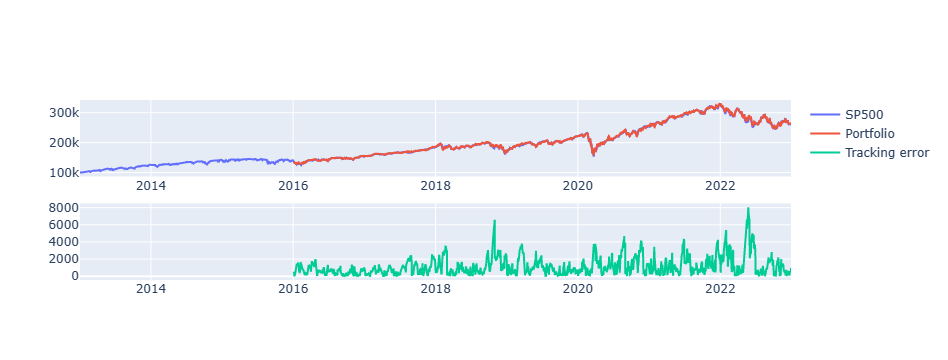

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )
fig.show()

In [58]:
Benchmark.to_csv('b.csv')
di.to_csv('d.csv')

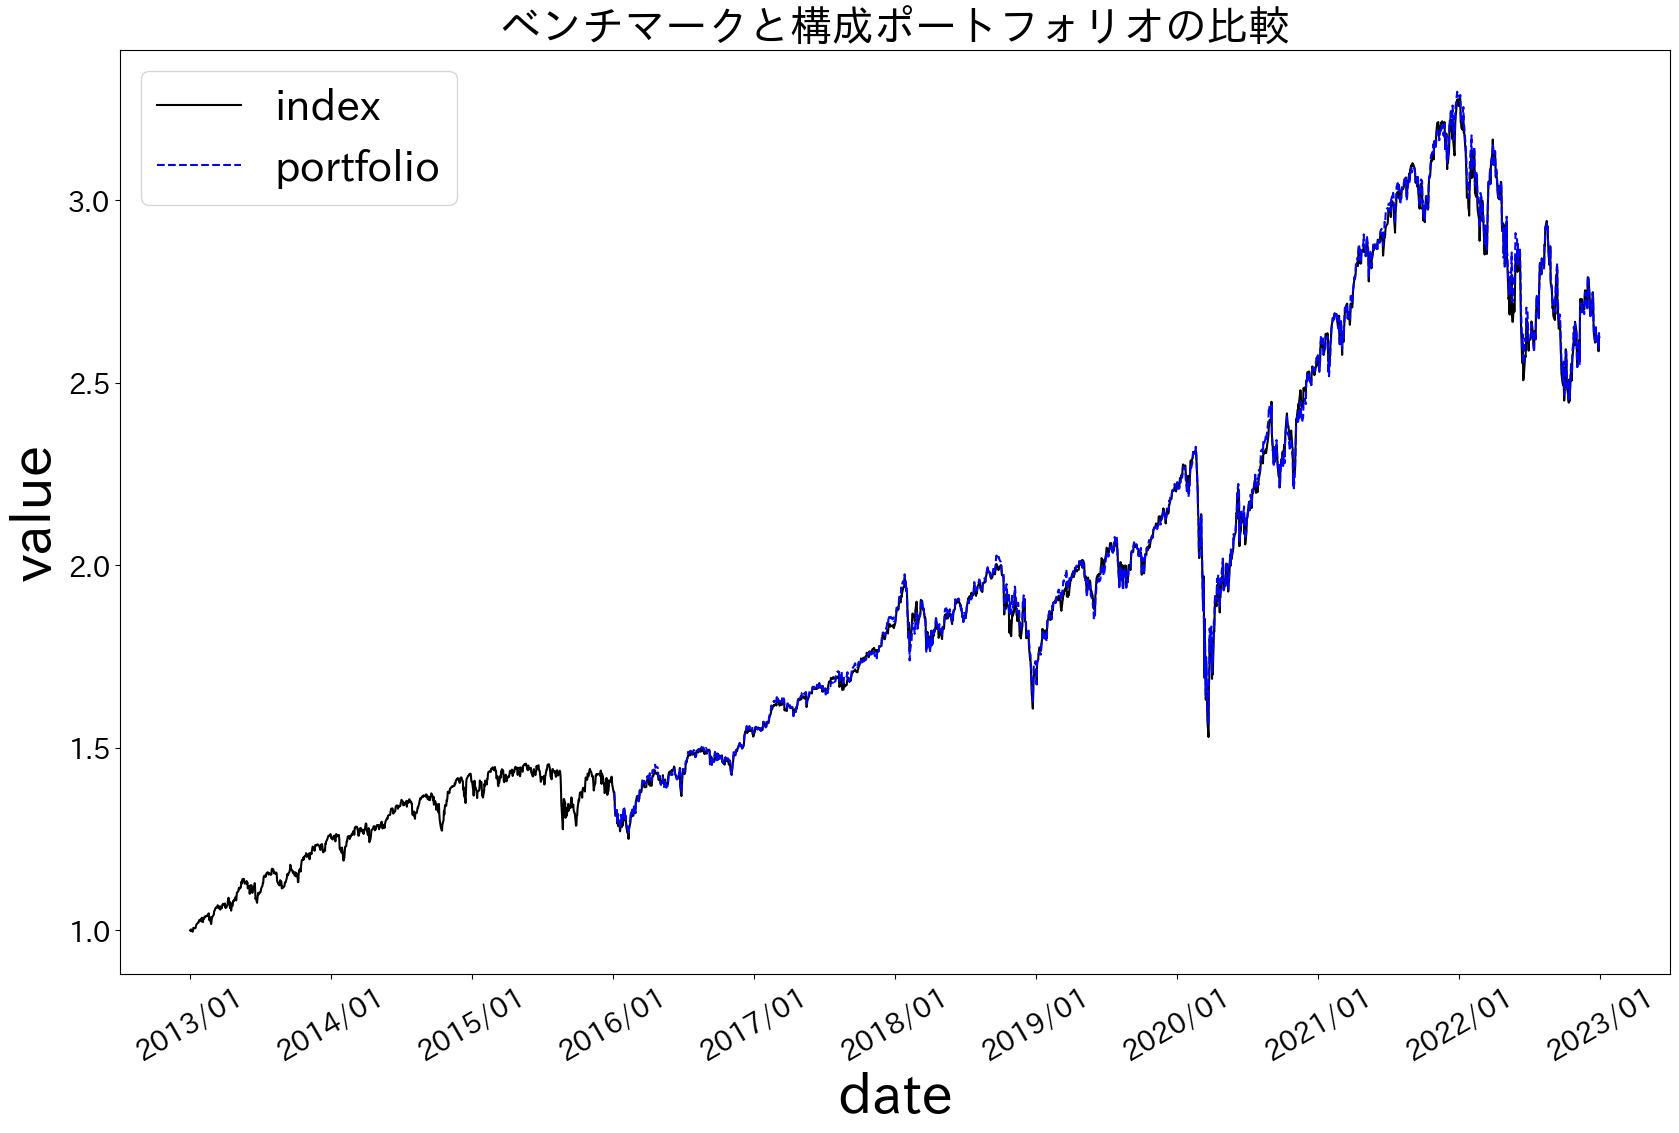

In [69]:
import japanize_matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111)
ax.plot(pd.to_datetime(Benchmark.index),Benchmark,c='k')
ax.plot(pd.to_datetime(di.index),di,c='b',linestyle="--")
ax.legend(labels=['index','portfolio'],fontsize=30)
ax.set_xlabel('date', size=40)
ax.set_ylabel('value', size=40)
ax.set_title('ベンチマークと構成ポートフォリオの比較', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
fig.savefig("di.png")

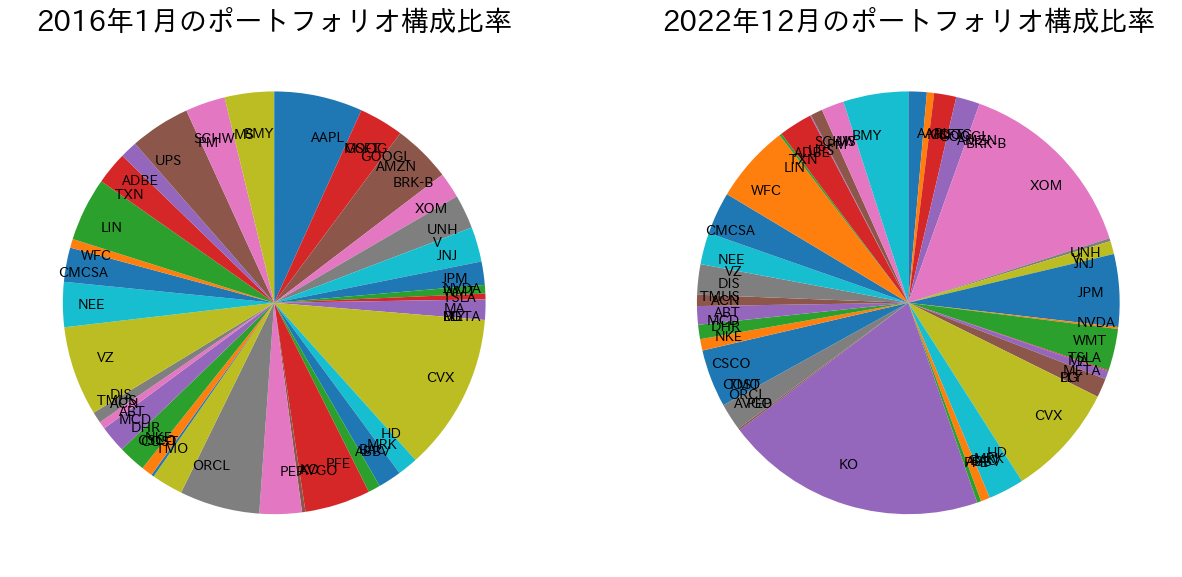

In [83]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(121)
ax.pie(dw.iloc[0,:],labels=tickers, counterclock=False, startangle=90, labeldistance=0.8)
ax.set_title('2016年1月のポートフォリオ構成比率', fontsize=20)
ax = fig.add_subplot(122)
ax.pie(dw.iloc[83,:],labels=tickers, counterclock=False, startangle=90, labeldistance=0.8)
ax.set_title('2022年12月のポートフォリオ構成比率', fontsize=20)
fig.savefig("pie.png")